In [52]:
import tensorflow as tf
import matplotlib.pyplot as plt
import PIL.Image as pil
from tensorflow.keras.applications import MobileNetV2, mobilenet_v2
from tensorflow.keras.losses import CategoricalCrossentropy

In [51]:
PATH = '/kaggle/input/adversarial-examples-images/macaw.jpg'
MACAW_INDEX = 88

## Importing the Image

In [6]:
pil_image = pil.open(PATH)
image_tensor = tf.convert_to_tensor(tf.keras.utils.img_to_array(pil_image), dtype=tf.float32)
image_tensor

<tf.Tensor: shape=(5328, 2592, 3), dtype=float32, numpy=
array([[[  0.,  19.,   2.],
        [  0.,  19.,   2.],
        [  0.,  20.,   3.],
        ...,
        [150., 144., 118.],
        [156., 150., 124.],
        [152., 146., 120.]],

       [[  0.,  19.,   2.],
        [  0.,  20.,   3.],
        [  0.,  21.,   4.],
        ...,
        [152., 146., 122.],
        [157., 151., 127.],
        [155., 149., 125.]],

       [[  0.,  20.,   3.],
        [  0.,  20.,   3.],
        [  0.,  21.,   4.],
        ...,
        [151., 145., 123.],
        [156., 150., 128.],
        [156., 150., 128.]],

       ...,

       [[  1.,  79.,  29.],
        [  0.,  78.,  28.],
        [  0.,  78.,  28.],
        ...,
        [  1.,  10.,   5.],
        [  0.,  11.,   5.],
        [  1.,  12.,   6.]],

       [[  1.,  77.,  28.],
        [  1.,  77.,  28.],
        [  0.,  76.,  27.],
        ...,
        [  0.,   9.,   1.],
        [  0.,   8.,   3.],
        [  0.,   8.,   3.]],

       [[  1., 

## Preprocessing

In [11]:
def preprocess(image_tensor) :
    image = tf.image.resize(image_tensor, (224, 224))
    image = mobilenet_v2.preprocess_input(image) # preparing the input for MobileNetV2
    image = tf.expand_dims(image, axis=0) # adding the batch dimension
    return image

In [12]:
image = preprocess(image_tensor)

## MobileNetV2

In [13]:
model = tf.keras.applications.MobileNetV2(include_top=True, weights='imagenet')
model.trainable = False # our objective is to find an adversarial example and not training a model

# It maps predicted probabilities to class labels, providing a more user-friendly 
# representation of the model's predictions for image classification tasks
decoder = mobilenet_v2.decode_predictions

14536120/14536120 [==============================] - 0s 0us/step


## Tesing on The Original Image

In [46]:
def get_labels(prediction, decoder) :
    # top=1 : only returns the best guess
    # the decoder returns a list of lists of top class prediction tuples.
    return decoder(prediction, top=1)[0][0]

In [84]:
def show_image(image, title) :
    plt.figure(figsize=(5, 9))
    # pixels are in range [-1, 1], so the range should be changed to [0, 1]
    plt.imshow(image[0] * 0.5 + 0.5) 
    # second and third elements in the tuple are the most likely class and its probability
    plt.title(title)
    plt.show()

In [85]:
prediction = model.predict(image)
number_of_classes = prediction.shape[-1] # the output is in the shape of (#Batches, #Classes)

1/1 [==============================] - 0s 24ms/step


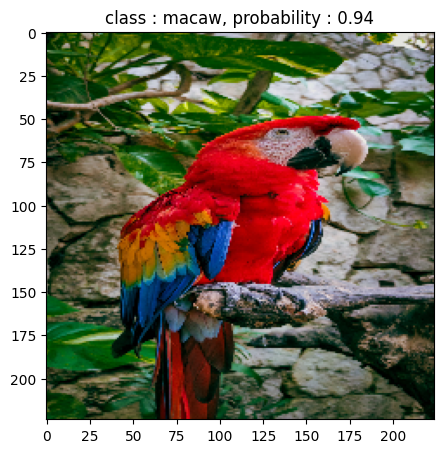

In [86]:
_, image_class, class_probability = get_labels(prediction, decoder)
title = f'class : {image_class}, probability : {class_probability:.2f}'
show_image(image, title)

## Fast Gradient Sign Method

In [92]:
def get_gradients_sign(model, image, label, categorical_crossentropy) :
    with tf.GradientTape() as tape :
        tape.watch(image) # we will calculate gradient of loss with respect to the input image
        prediction = model(image)
        loss = categorical_crossentropy(label, prediction)
    gradient = tape.gradient(loss, image)
    gradient_sign = tf.sign(gradient)
    return gradient_sign, gradient

In [93]:
label = tf.one_hot(MACAW_INDEX, number_of_classes)
label = tf.reshape(label, (1, number_of_classes))

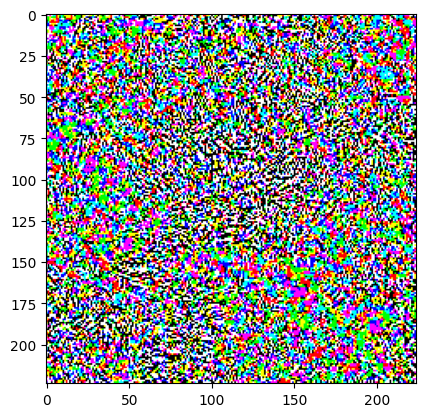

In [94]:
gradients_signs, _ = get_gradients_sign(model, image, label, CategoricalCrossentropy())
plt.imshow(gradients_signs[0])

1/1 [==============================] - 0s 22ms/step


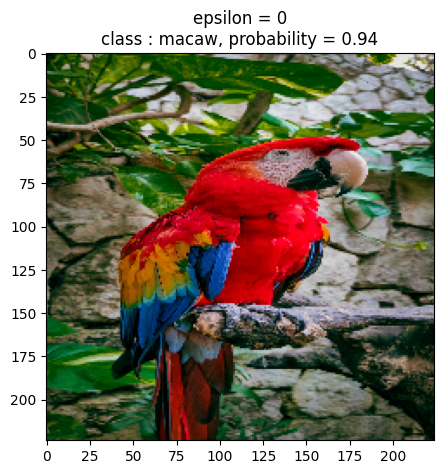

1/1 [==============================] - 0s 23ms/step


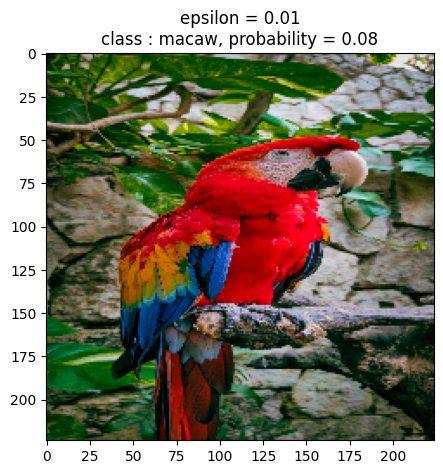

1/1 [==============================] - 0s 22ms/step


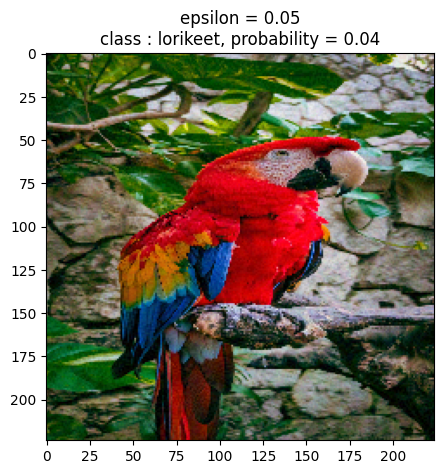

1/1 [==============================] - 0s 23ms/step


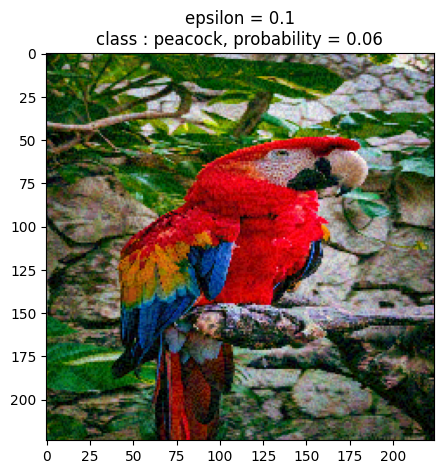

1/1 [==============================] - 0s 24ms/step


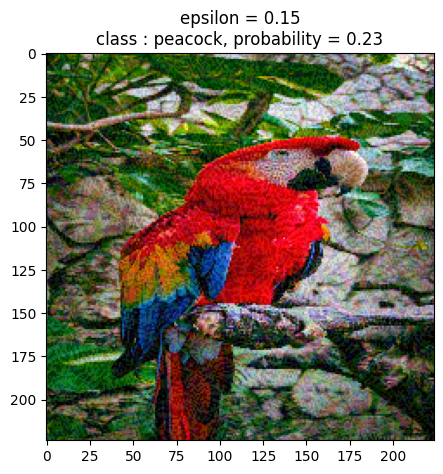

1/1 [==============================] - 0s 23ms/step


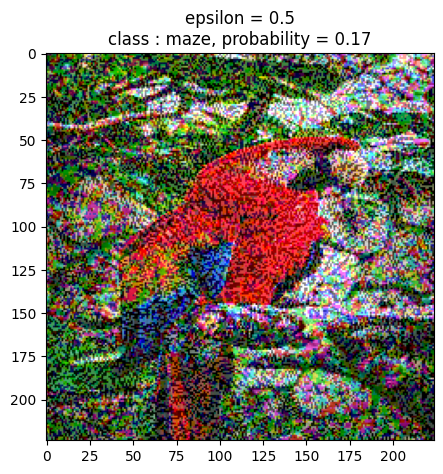

1/1 [==============================] - 0s 25ms/step


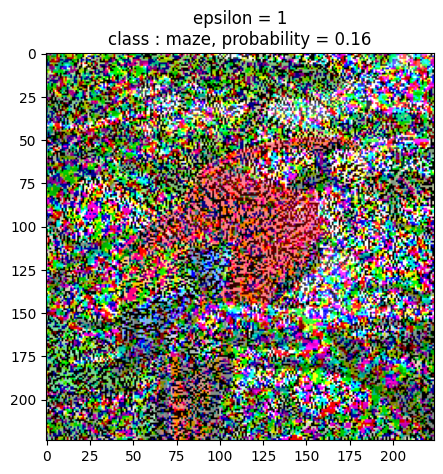

In [95]:
for epsilon in [0, 0.01, 0.05, 0.1, 0.15, 0.5, 1] :
    adversarial_image = image + epsilon * gradients_signs
    
    prediction = model.predict(adversarial_image)
    _, image_class, class_probability = get_labels(prediction, decoder)
    
    title = f'epsilon = {epsilon}\nclass : {image_class}, probability = {class_probability:.2f}'
    adversarial_image = tf.clip_by_value(adversarial_image, -1, 1) # pixels have to be in [-1, 1]
    show_image(adversarial_image, title)